# `PHAS0102 Assignment 3 - sparse matrices`

In [291]:
import matplotlib.pyplot as plt
import numpy as np
import scipy 
from scipy import sparse
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import LinearOperator, cg, gmres
from timeit import timeit
from tqdm import tqdm

## `Part 1: Implementing a CSR matrix`

`SciPy` allows you to define your own objects that can be used with their sparse solvers. We will create a subclass of `scipy.sparse.LinearOperator`. In this, we will implement a CSR matrix format manually. Below `__add__` method converts CSR to COO, computes the sum, and converts back into CSR.

In [277]:
class CSRMatrix(LinearOperator):
    def __init__(self, coo_matrix):
        # store matrix shape and data type
        self.shape = coo_matrix.shape
        self.dtype = coo_matrix.dtype

        # extract row, column indices and data from COO matrix
        row = coo_matrix.row
        col = coo_matrix.col
        data = coo_matrix.data

        # sort COO entries by row
        order = np.argsort(row)
        row = row[order]
        col = col[order]
        data = data[order]

        # initialise CSR index pointer
        indptr = [0]
        counter = 0

        # build indptr array
        n_rows = self.shape[0]
        for i in range(n_rows-1):
            counter += np.count_nonzero(row == i)
            indptr.append(counter)
            
        nnz = len(row)
        indptr.append(nnz)

        # store CSR arrays in object
        self.data = data
        self.indices = col
        self.indptr = indptr

    def __add__(self, other):
        'add the CSR matrix other to this matrix'

        # ensure matrices have the same shape
        assert self.shape == other.shape

        ## matrix 1 CSR -> COO ##
        # reconstruct row indices from indptr
        row_self = np.repeat(
                        np.arange(self.shape[0]),
                        np.diff(self.indptr))

        col_self = self.indices
        data_self = self.data

        ## matrix 2 CSR -> COO ##
        # reconstruct row indices from indptr
        row_other = np.repeat(
                        np.arange(other.shape[0]),
                        np.diff(other.indptr))

        col_other = other.indices
        data_other = other.data

        # concatenate matrix data
        rows = np.concatenate((row_self, row_other))
        cols = np.concatenate((col_self, col_other))
        data = np.concatenate((data_self, data_other))

        # sort by row and column
        order = np.argsort(rows)
        rows = rows[order]
        cols = cols[order]
        data = data[order]

        # create boolean mask for identifying unique (row, col) pairs
        unique_mask = np.ones(len(data), dtype=bool)
        unique_mask[1:] = ~((rows[1:] == rows[:-1]) & (cols[1:] == cols[:-1]))
        unique_indices = np.where(unique_mask)[0]

        # sum duplicate entries
        new_data = np.add.reduceat(data, unique_indices)
        new_rows = rows[unique_indices]
        new_cols = cols[unique_indices]

        # convert arrays back into COO matrix
        from scipy.sparse import coo_matrix
        coo = coo_matrix((new_data, (new_rows, new_cols)), shape=self.shape)

        # return CSR matrix object 
        return CSRMatrix(coo)

    
    def _matvec(self, vector):
        'compute a matrix-vector product'

        # ensure vector length matches number of columns
        assert self.shape[1] == vector.shape[0]
        
        # initialise result vector
        result = np.zeros(self.shape[0], dtype=vector.dtype)

        # loop over each row
        for i in range(self.shape[0]):
            start = self.indptr[i]
            end = self.indptr[i+1]

            # loop over elements in row, calculating matrix entry
            for j in range(start, end):
                result[i] += self.data[j] * vector[self.indices[j]]
    
        return result

#### `testing methods`

In [278]:
## testing addition ##

for i in range(4,10):
    A_coo = sparse.random(i,i,density=0.2)
    B_coo = sparse.random(i,i,density=0.2)
    
    A_csr = CSRMatrix(A_coo)
    B_csr = CSRMatrix(B_coo)
    
    C_coo = A_coo + B_coo
    C_coo = C_coo.toarray()
    
    C_csr = A_csr + B_csr
    C_csr = csr_matrix((C_csr.data, C_csr.indices, C_csr.indptr), shape=C_csr.shape).toarray()

    assert np.allclose(C_coo, C_csr)
print(f'! CSR addition works for 4x4 to 9x9 matrices !')

! CSR addition works for 4x4 to 9x9 matrices !


In [279]:
## testing matrix-vector multiplication ##

for i in range(4,10):
    A_coo = sparse.random(i,i,density=0.2)
    A_csr = CSRMatrix(A_coo)
    
    vector = np.random.rand(i)
    
    y_coo = A_coo @ vector
    y_csr = A_csr @ vector

    assert np.allclose(y_coo, y_csr)
print(f'! CSR matrix-vector multiplication works for 4x4 to 9x9 matrices !')

! CSR matrix-vector multiplication works for 4x4 to 9x9 matrices !


### `matrix-vector multiplication speed comparison`

In [347]:
# testing matvec speeds for range of matrix sizes

sizes = np.arange(10,1001,25)

matvec_times = []
numpy_times = []

for i in tqdm(sizes):
    coo = sparse.random(i,i,0.4)
    csr = CSRMatrix(coo)
    dense = coo.toarray()
    vector = np.random.rand(i)

    matvec_time = timeit(lambda: csr @ vector, globals=globals(), number=10)/10
    matvec_times.append(matvec_time)
    
    numpy_time = timeit(lambda: dense @ vector, globals=globals(), number=10)/10
    numpy_times.append(numpy_time)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]


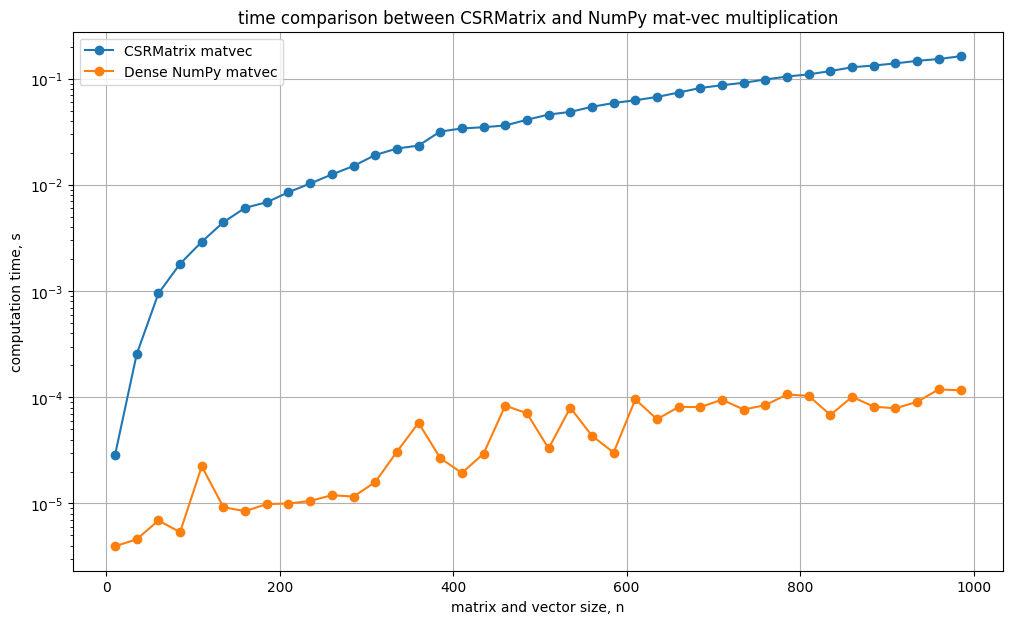

In [349]:
sizes = np.arange(10,1001,25)

plt.figure(figsize=(12,7))
plt.plot(sizes, matvec_times, 'o-', label='CSRMatrix matvec')
plt.plot(sizes, numpy_times, 'o-', label='Dense NumPy matvec')

plt.title('time comparison between CSRMatrix and NumPy mat-vec multiplication')
plt.xlabel('matrix and vector size, n')
plt.ylabel('computation time, s')

plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

As we can see the `CSRMatrix` matric-vector multiplcation scales quadratically due to the double `for` loop within the `_matvec` method. `NumPy` implements a highly optimised multiplication method so increase in computation time doesn't increase as rapidly as for `CSRMatric`.

### `solving matrix problems w/ sparse solvers`
Here we wil solve $\mathrm{A}x = b$ for $x$, where $\mathrm{A}$ is some matrix, and $b$ is some vector. We will use SciPy's `gmres` and `cg` sparse solvers. We will test with randomly generated sparse matrices.

#### `randomly generated matrices`

In [330]:
n = 8
A = scipy.sparse.random(n,n,density=0.3)
A_csr = CSRMatrix(A)
b = np.random.rand(n)

In [331]:
# gmres
x_gmres, info_gmres = gmres(A_csr,b)
assert np.allclose(A_csr @ x_gmres, b)

In [335]:
# cg
x_cg, info_cg = cg(A_csr, b)
assert np.allclose(A_csr @ x_cg, b)

C:\Users\dhruv\AppData\Local\Temp\ipykernel_20776\2313215468.py:105: RuntimeWarning: invalid value encountered in scalar add
  result[i] += self.data[j] * vector[self.indices[j]]


AssertionError: 

`scipy.sparse.linalg.cg` has a requirement for input matrices to be symmetric positive definite, which the randomly generated matrix is unlikely to satisfy. `scipy.sparse.linalg.gmres` does not have this requirement, therefore `gmres` works for most matrices where `cg` fails.

## `Part 2: Implementing a custom matrix`
$\text{A}$ is a $2n \times 2n$ matrix with the following structure:
- top left $n \times n$ block of $\text{A}$ is a diagonal matrix
- top right $n \times n$ block of $\text{A}$ is $\textbf{0}$
- bottom left $n \times n$ block of $\text{A}$ is $\textbf{0}$
- bottom right $n \times n$ block of $\text{A}$ is specially defined dense matrix $\tilde{\mathrm{A}}$:

$$\tilde{\mathrm{A}} = \text{TW}$$
where $\mathrm{T}$ is a $n \times 2$ 'tall' matrix, and $\mathrm{W}$ is a $2 \times n$ 'wide' matrix.

We will implement a subclass of `scipy.sparse.LinearOperator` for these matrices, including a `_matvec` method, ensuring minimum computational complexity.

In [282]:
class CustomMatrix(LinearOperator):
    def __init__(self, diag, T, W):
        'construct matrix'

        # asserting flat input
        assert diag.ndim == 1

        # unpacking diagonal shape
        n = diag.shape[0]

        # asserting 'tall' and 'wide' matrix shapes
        assert T.shape[0] == n and T.shape[1] == 2
        assert W.shape[0] == 2 and W.shape[1] == n

        # set matrix dimensions and data type
        self.shape = (2*n, 2*n)
        self.dtype = T.dtype

        # store diagonals and T and W matrices
        self.diag = diag
        self.T_mat = T
        self.W_mat = W

    def _matvec(self, vector):
        'compute matrix-vector product'
        
        # ensure vector length matches number of columns
        assert self.shape[1] == vector.shape[0]

        # splitting vector into upper and lower blocks for matvec multiplication
        n = vector.shape[0] // 2
        x1 = vector[:n]
        x2 = vector[n:]

        # top left block multiply - elementwise multiply for diagonal matrix
        diag_prod = self.diag * x1

        # bottom right block multiply (T * (W * x2))
        W_x2 = self.W_mat @ x2
        A_prod = self.T_mat @ W_x2

        # concatenate top and bottom results
        product = np.concatenate([diag_prod, A_prod])
            
        return product

### `matrix-vector multiplication speed comparison`

In [287]:
sizes = np.arange(2,2022,20)
dense_times = []
fast_times = []

for n in tqdm(sizes):
    # random input matrices
    diag = np.random.rand(n)
    T = np.random.rand(n,2)
    W = np.random.rand(2,n)

    # construct matrix objects
    A = CustomMatrix(diag, T, W)
    A_dense = np.zeros((2*n, 2*n))

    # fill non-zero dense matrix blocks
    A_dense[:n, :n] = np.diag(diag)
    A_dense[n:, n:] = T @ W

    # random input vector
    x = np.random.rand(2*n)

    # output check
    assert np.allclose(A_dense @ x, A @ x)

    # timing
    dense_time = timeit(lambda:A_dense @ x, globals=globals(), number=50)/50
    dense_times.append(dense_time)
    
    fast_time = timeit(lambda:A @ x, globals=globals(), number=50)/50
    fast_times.append(fast_time)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:08<00:00, 11.98it/s]


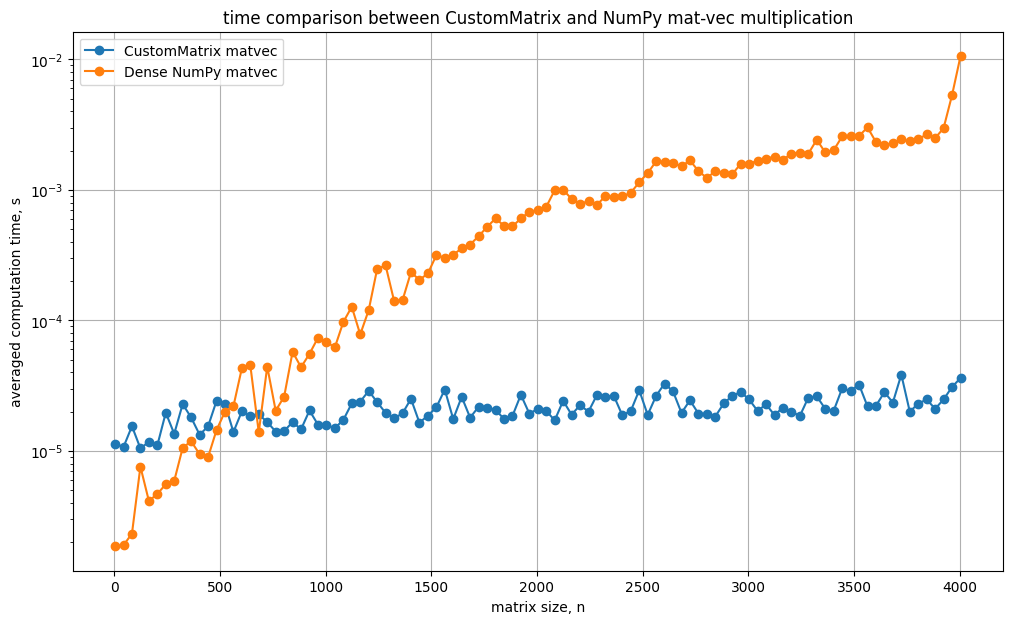

In [340]:
sizes = np.arange(2,2022,20)

plt.figure(figsize=(12,7))
plt.plot(2*sizes, fast_times, 'o-', label='CustomMatrix matvec')
plt.plot(2*sizes, dense_times, 'o-', label='Dense NumPy matvec')

plt.title('time comparison between CustomMatrix and NumPy mat-vec multiplication')
plt.xlabel('matrix size, n')
plt.ylabel('averaged computation time, s')

plt.yscale('log')
plt.grid()
plt.legend()

plt.show()

Initially `NumPy` performs better than `CustomMatrix`, however after a threshold at roughly $\mathrm{n}=500$, computation time for `NumPy` increases drastically. This is due to the two-part matrix-vector multiplication method in `CustomMatrix` where only the bottom-right component of the matrix, $\mathrm{\tilde{A}}$ significantly contributes to computational complexity. The $\textbf{0}$ components of the matrix do not contribute, and the top left diagonal component contributes less significantly, due to it being a simple elementwise multiplication. `NumPy` takes all components of the matrix into account during multiplication, even if there are components equal to 0. Hence, after a certain threshold, `CustomMatrix` performs better.